In [4]:
%load_ext autoreload
%autoreload 2

In [13]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import timeit
import h5py
from pathlib import Path
import numpy as np
from itertools import product
import pickle
import scipy.special
import scipy.stats
from math import exp
import multiprocessing
import functools

from montecarlo import FK_mcmc, FK_mcmc_auto_reflect
from montecarlo import DataLogger
from general import running_mean

%matplotlib inline
np.seterr(all='warn')
textwidth = 6.268
mpl.rcParams['figure.dpi'] = 70
default_figargs = dict(figsize = (textwidth,textwidth))

In [41]:
%%time
from direct_partition_functions import direct, states_to_numbers, number_to_state, enumerate_states
from montecarlo import FK_mcmc_multi_site, Observables, FK_mcmc_perturbation

N = 50
beta = 1/10
U = 1
J = 5
mu = 0
t = 1
alpha = 1.5
state = (np.arange(N) % 2)
mcmc_steps = np.array([50, 1e2], dtype = np.int)
N_steps = max(mcmc_steps)
N_burn_in = 0

#log = FK_mcmc_random_pair(
#log = FK_mcmc_multi_site(
log =  FK_mcmc_perturbation(
    state=np.zeros(N),            
    N_steps = N_steps, N_burn_in = N_burn_in,
    mu = mu, beta = beta, J = J, alpha=alpha, U = U, t=t,
    logger = Observables(), normalise = True, N_multi_site = 50,
    )

print(f'p_acc = {log.p_acc}')
print(f'multi step saving = {1 - log.p_facc}')

Warning, p_acc = 0.7731999999999999, mu = 0, beta = 0.1, J = 5
p_acc = 0.7731999999999999
multi step saving = 0.13319999999999999
CPU times: user 5.36 s, sys: 60 ms, total: 5.42 s
Wall time: 1.36 s


MemoryError: 

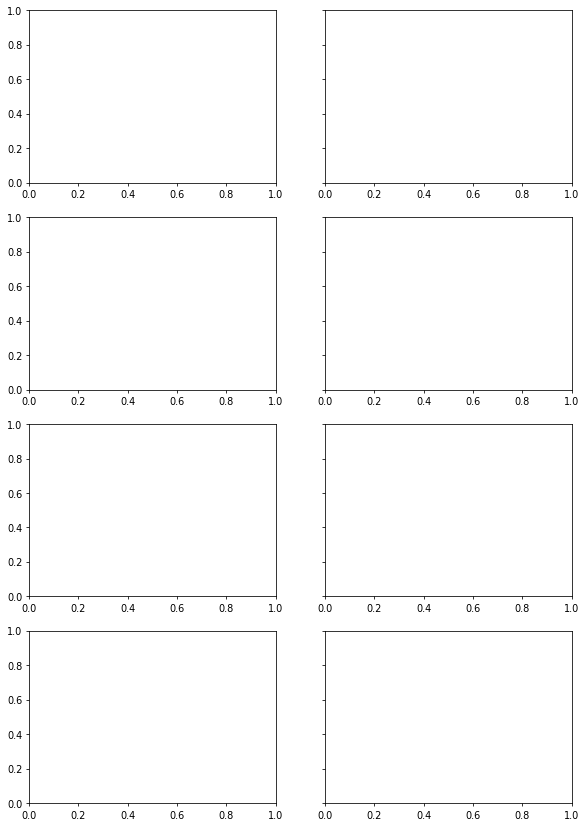

In [35]:
f, axes = plt.subplots(4,len(mcmc_steps), figsize = (5*len(mcmc_steps), 5*3), sharey = 'row')
for N_mc_steps, ax in zip(mcmc_steps, axes.T):

    #don't use the whole mcmc run, just the first N_mc_steps to see if it's converging
    chunksize = int(N_mc_steps/5)
    chunks = mc_state_labels[:N_mc_steps].reshape(-1,chunksize)
    binned_chunks = np.array([np.bincount(chunk) for chunk in chunks])
    dmc_label_count = scipy.stats.sem(binned_chunks, axis = 0)
    
    mc_label_count = np.bincount(mc_state_labels[:N_mc_steps])
    mc_label_count = mc_label_count[ix]
    dmc_label_count = dmc_label_count[ix]
    
    ax[0].set(title = f'{N_mc_steps} MC steps', xlabel = 'state label')
    
    ax[0].plot(np.arange(2**N), Ps, '--x')
    ax[0].errorbar(np.arange(2**N), mc_label_count/np.sum(mc_label_count),
                yerr= dmc_label_count/np.sum(mc_label_count), fmt = '.')
    
    for a, x, xlabel in zip(ax, 
                            [np.arange(2**N), Ffs + Fcs, Nfs+Ncs, Mf_moments[1],Mf_moments[2]],
                            ['State label','Total Free energy', 'N', 'M', 'M**2']):
        i = np.argsort(x)
        a.plot(x[i], Ps[i], '--x')
        a.errorbar(x[i], mc_label_count[i]/np.sum(mc_label_count),
                    yerr= dmc_label_count[i]/np.sum(mc_label_count), fmt = '.')
        a.set(xlabel = xlabel)

for ax in axes: ax[0].set(ylabel = 'State Probability');

To check the sanity of the monte carlo routine, the above plot compares the boltzman factor $exp(-\beta F) $ for each state of a small system (N=6) with the number of occurances seen during a monte carlo run. Each column shows these factors after an increasing number of montecarlo steps. Each row represents the states by a differnt measure, first they're simply ordered by increasing free energy, second they're plotted against free energy so that degernate states clump together. The 3rd and 4th show the overall occupation $Nf + Nc$ and the squared staggered magnetisation. 

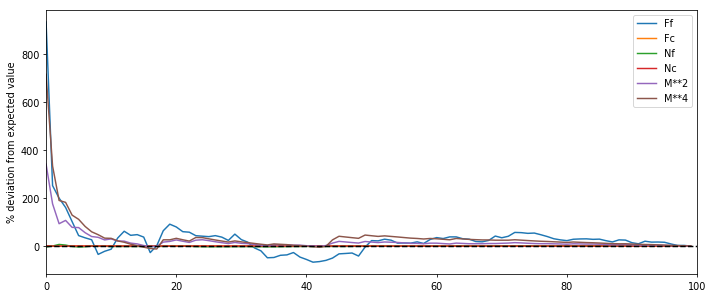

In [44]:
observables = [log.Ff, log.Fc,log.Nf,log.Nc,log.Mf_moments[2], log.Mf_moments[4]]
labels = ['Ff', 'Fc', 'Nf', 'Nc', 'M**2', 'M**4']

f, ax = plt.subplots(1,1, figsize = (12,5), sharex = 'all', gridspec_kw=dict(hspace = 0.5))

for x, label in zip(observables, labels):
    mean = np.mean(x)
    ax.plot(np.arange(x.shape[0]), (running_mean(x)-mean)/mean * 100, label = label)

ax.plot((0,x.shape[0]),(0,0), 'k--')
ax.set(ylabel = '% deviation from expected value', xlim = (0,min(1000, x.shape[0])))
ax.legend()

The above plot shows the mean of each observable after x monte carlo steps, showing gradual convergence. Currently the Ff, Fc and Nc observables don't converge to the correct values!

In [180]:
%%time
from direct_partition_functions import direct, states_to_numbers, number_to_state, enumerate_states
from montecarlo import *
import time

N = 15
beta = 1/0.1
U = 1
J = 5
mu = 0
t = 1
alpha = 1.5
state = np.zeros(N, dtype = np.float64)
N_steps = int(1e4)
N_burn_in = 0

funcs = [
    mcmc_multi_site_variable_reflect,  
    #mcmc_typewriter,
    #mcmc_random_site, 
    #mcmc_multi_site_variable, mcmc_multi_site_variable_reflect,
    #mcmc_typewriter_p, mcmc_random_site_p, mcmc_multi_site_variable_p, 
        ]

logs = dict()

for func in funcs:
    print(f'starting {func.__name__}')
    t0 = time.time()
    logs[func.__name__] =  func(
        state = (np.arange(N) % 2),            
        N_steps = N_steps, N_burn_in = N_burn_in,
        mu = mu, beta = beta, J = J, alpha=alpha, U = U, t=t,
        logger = Observables(), normalise = True, N_multi_site = 5,
        )
    print(f'took {time.time()-t0 :.2f} seconds\n')

starting mcmc_multi_site_variable_reflect
Warning, p_acc = 0.5703, mu = 0, beta = 10.0, J = 5
took 35.02 seconds

CPU times: user 34 s, sys: 32 ms, total: 34 s
Wall time: 35 s


In [179]:
logs['mcmc_multi_site_variable_reflect'].accept_rates

array([    0., 10007., 10173.,  9981., 10029.,  9903.,  9982.,  9935.,
        9937.,  9881.,  9916., 10053.,  9840.,  9975.,  9815.,  9681.])

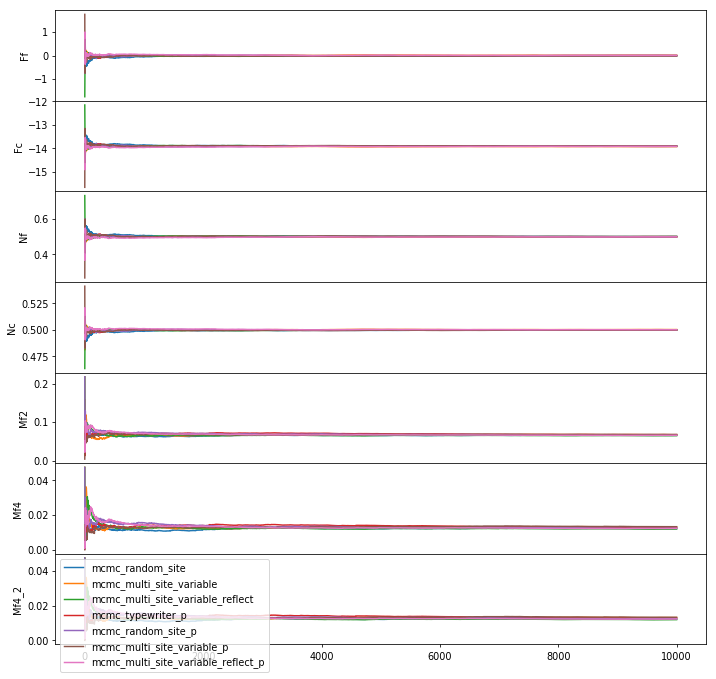

In [164]:
f, axes = plt.subplots(7,1, figsize = (12,12), sharex = 'all', gridspec_kw=dict(hspace = 0))

for name, log in logs.items():
    
    observables = dict(Ff = log.Ff, Fc = log.Fc,
                       Nf = log.Nf, Nc = log.Nc,
                       Mf2 = log.Mf_moments[2],
                       Mf4 = log.Mf_moments[4],
                       Mf4_2 = log.Mf_moments[4])
    
    for (ylabel, data), ax in zip(observables.items(), axes):
        if name == 'FK_mcmc_auto_reflect_random_site': continue
        ax.plot(np.linspace(0,N_steps,data.shape[0]), running_mean(data), label = name)
        ax.set(ylabel = ylabel)
axes[-1].legend()

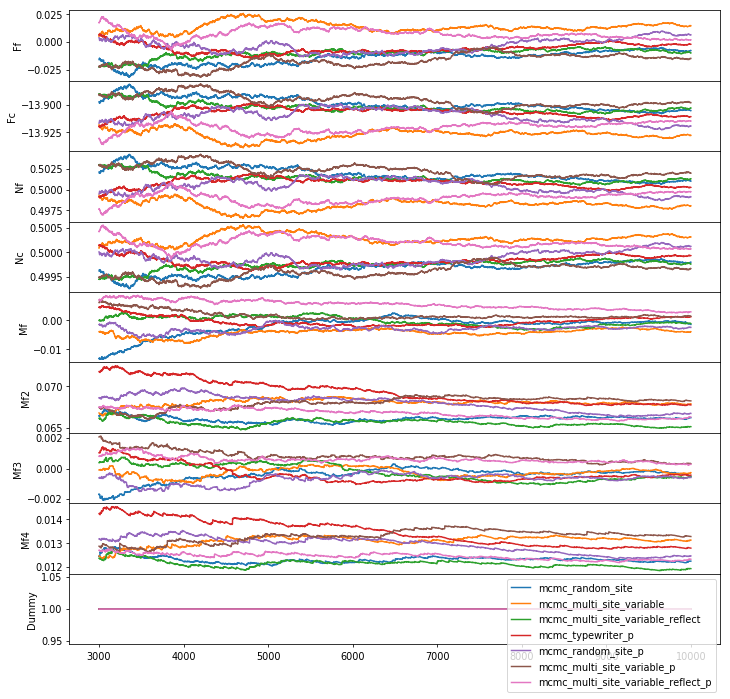

In [168]:
f, axes = plt.subplots(9,1, figsize = (12,12), sharex = 'all', gridspec_kw=dict(hspace = 0))

for name, log in logs.items():
    observables = dict(Ff = log.Ff, Fc = log.Fc,
                       Nf = log.Nf, Nc = log.Nc,
                       Mf = log.Mf_moments[1],
                       Mf2 = log.Mf_moments[2],
                       Mf3 = log.Mf_moments[3],
                       Mf4 = log.Mf_moments[4],
                       Dummy = log.Mf_moments[0])
    
    for (ylabel, data), ax in zip(observables.items(), axes):
        x = np.linspace(0,N_steps,data.shape[0])
        xlim = (3000,10000)
        y = running_mean(data)
        i = slice(*np.searchsorted(x, xlim))
        y_slice = y[i]
        x_slice = x[i]
        ax.set(ylabel = ylabel)
        ax.plot(x_slice, y_slice, label = name)
        
axes[-1].legend()

In [18]:
%%time
from direct_partition_functions import direct
from montecarlo import *

N_steps = int(1 * 1000)
N_burn_in = int(0.1 * 1000)

MCMC_params = dict(
        N_steps = N_steps, N_burn_in = N_burn_in, 
        state=None, 
        logger = Magnetisation_cumulants(N_cumulants = n_cumulants),
        proposal = p_uncorrelated_proposal,
        accept_function = simple_accept,
    )

Js = [1,5]
mu = np.linspace(-5,5,30)
Ns = [20,40,80]
occupation_params = dict(t = 1, alpha = 1.5, mu = None, beta = 1/2, J = None, U = 0, normalise = True)

def compute(mu, **kwargs):
    kwargs['parameters']['mu'] = mu
    return FK_mcmc_2(**kwargs)


data = np.zeros(shape = (len(Js), len(Ns), 4, len(mu)))

with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for Jslice, J in zip(data, Js):
        for Nslice, N in zip(Jslice, Ns):
            #print(J, N)

            curried = functools.partial(compute, state=np.random.choice(a = [0,1], size = N), 
                    N_steps = N_steps, N_burn_in = N_burn_in, 
                    J=J, alpha=alpha, U=U, t=t,
                    logger = NfNc(), normalise = normalise)
                
            mc_Nf, mc_Nc, mc_dNf, mc_dNc = np.array(pool.map(curried, mu)).T
            
            np.copyto(Nslice, np.array([mc_Nf, mc_Nc, mc_dNf, mc_dNc]))

np.savez('./pickled_data/density_vs_mu.npz', 
         beta=beta, U=U, t=t, mu=mu, Ns=Ns, Js=Js, alpha=alpha, N_steps = N_steps, N_burn_in=N_burn_in,
        data=data, normalise=normalise,
        )
print('done')

Warning, p_acc = 0.9536363636363636, mu = -0.8620689655172411, beta = 0.1, J = 1
Warning, p_acc = 0.9136363636363637, mu = -1.5517241379310343, beta = 0.1, J = 1
Warning, p_acc = 0.8554545454545455, mu = -2.9310344827586206, beta = 0.1, J = 1
Warning, p_acc = 0.89, mu = -2.2413793103448274, beta = 0.1, J = 1
Warning, p_acc = 0.7627272727272727, mu = -5.0, beta = 0.1, J = 1
Warning, p_acc = 0.8190909090909091, mu = -3.6206896551724137, beta = 0.1, J = 1
Warning, p_acc = 0.7954545454545454, mu = -4.310344827586206, beta = 0.1, J = 1
Warning, p_acc = 0.9654545454545455, mu = -0.5172413793103443, beta = 0.1, J = 1
Warning, p_acc = 0.94, mu = -1.206896551724138, beta = 0.1, J = 1
Warning, p_acc = 0.8518181818181818, mu = -2.586206896551724, beta = 0.1, J = 1
Warning, p_acc = 0.89, mu = -1.8965517241379306, beta = 0.1, J = 1
Warning, p_acc = 0.8118181818181818, mu = -3.275862068965517, beta = 0.1, J = 1
Warning, p_acc = 0.75, mu = -4.655172413793103, beta = 0.1, J = 1
Warning, p_acc = 0.7809

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


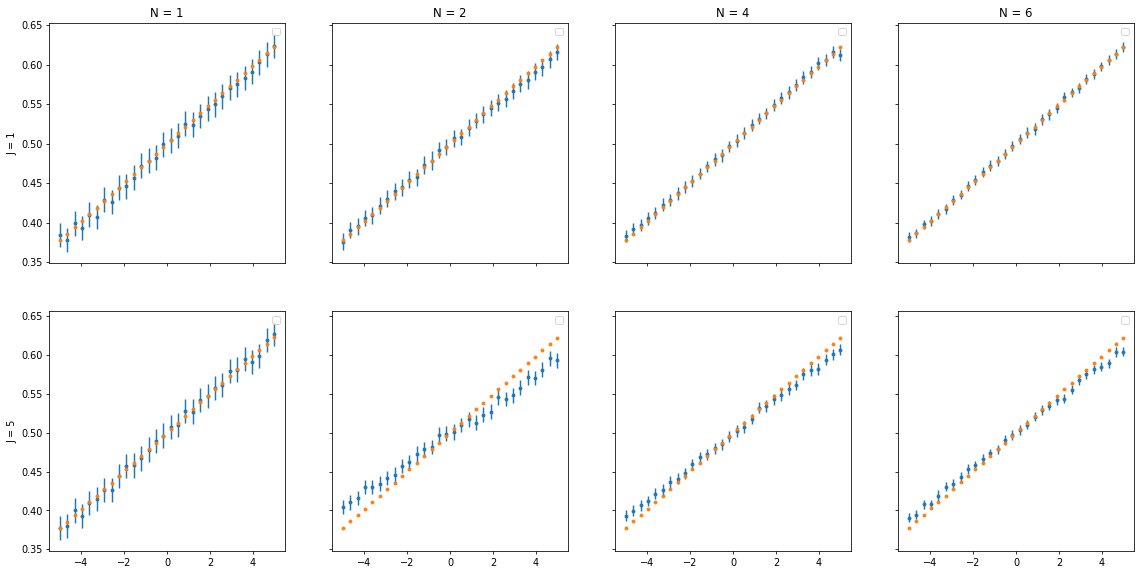

In [19]:
#%%time
data = np.load('./pickled_data/density_vs_mu.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Ns),figsize = (len(Ns)*5,len(Js)*5), sharex = 'col', sharey = 'row')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

for row, Jslice, J in zip(axes, data, Js):
    for ax, Nslice, N in zip(row, Jslice, Ns):
        mc_Nf, mc_Nc, mc_dNf, mc_dNc = Nslice
        
        ax.errorbar(mu, mc_Nf, yerr = mc_dNf, fmt = '.', color = colors[0])
        ax.errorbar(mu, mc_Nc, yerr = mc_dNc, fmt = '.', color = colors[1])
        ax.legend()
        
for ax,N in zip(axes[0],Ns): ax.set(title = f'N = {N}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 

In [26]:
from montecarlo import Magnetisation_cumulants
N_steps = 1000
N_burn_in = 100
n_cumulants = 5
T = np.linspace(0.05, 5, 30)
beta = 1/T
Ns = [30,50,80]
Us = [0,1,10]
Js = [0, 0.1, 1, 5]
t = 1
alpha = 1.5

def compute(b, **kwargs): 
    return FK_mcmc_auto_reflect(beta=b, **kwargs)


mcmc_binder_cumulants = np.zeros(shape = (len(Js), len(Us), len(Ns), 2, n_cumulants, len(beta)), dtype = np.float64)
with multiprocessing.Pool(multiprocessing.cpu_count() - 1) as pool:
    for slice1, J in zip(mcmc_binder_cumulants, Js):
        for slice2, U in zip(slice1, Us):
            for slice3, system_size in zip(slice2, Ns):
                print(U, J, system_size)
                curried = functools.partial(compute, state=np.random.choice([0,1],system_size), 
                    N_steps = N_steps, N_burn_in = N_burn_in, 
                    mu = 0, J=J, alpha=alpha, U=U, t=t,
                    logger=Magnetisation_cumulants(N_cumulants = n_cumulants))
                
                result = pool.map(curried, beta)
                #(beta, [non_central/central], powers) -> ([non_central/central], powers, beta)
                np.copyto(slice3, np.einsum('ijk->jki',result))

np.savez('./pickled_data/binder_cumulants_mcmc_larger.npz', 
         N_steps = N_steps, N_burn_in = N_burn_in,
         mcmc_binder_cumulants = mcmc_binder_cumulants,
        Ns=Ns, T=T, beta=beta,Us=Us,Js=Js,t=t,alpha=alpha,
        )
print('done!')

0 0 30
Warning, p_acc = 1.0, mu = 0, beta = 20.0, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.47658175842235, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.9309791332263241, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.5691854759568205, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 2.555066079295154, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 1.364705882352941, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.7064555420219244, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 4.53125, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.4407294832826748, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.8033240997229916, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 1.779141104294478, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.6304347826086957, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.518783542039356, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 1.1068702290076335, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.35957842529448236, J = 0
Warning, p_acc = 1.0, mu = 0, beta = 0.40989399293286216, J = 0
Warning, p_acc

/workspace/tch14/conda-envs/cmth_intelpython3_2/lib/python3.6/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


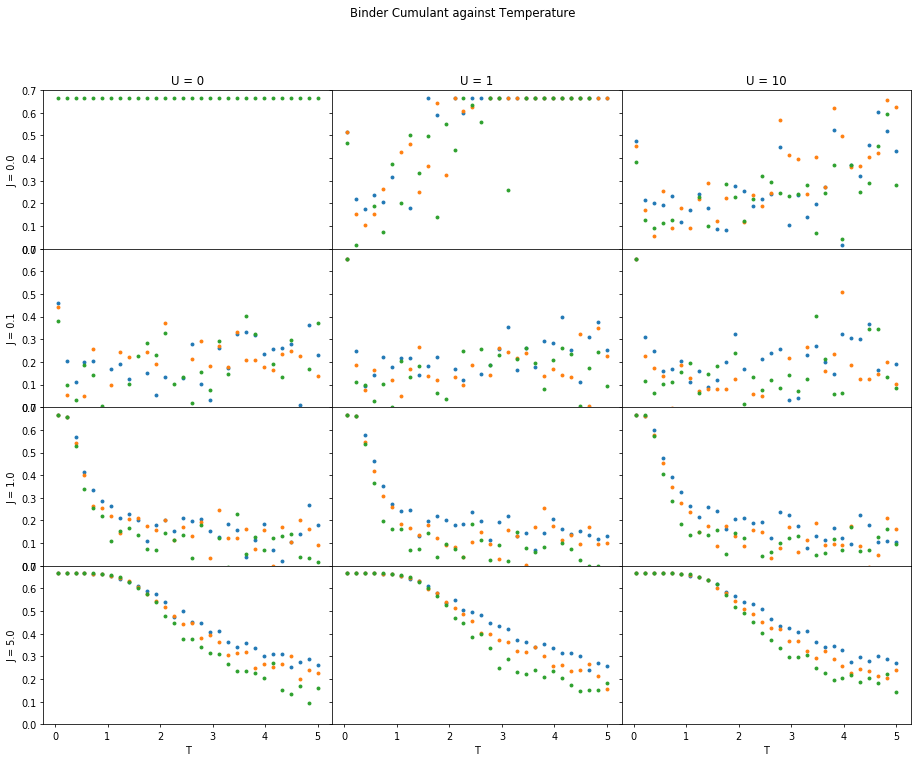

In [25]:
#%%time
from itertools import count
data = np.load('./pickled_data/binder_cumulants_mcmc_larger.npz')
locals().update(data)

f, axes = plt.subplots(len(Js),len(Us),figsize = (len(Js)*4,len(Us)*4), sharex = 'col', sharey = 'row', gridspec_kw = dict(hspace = 0, wspace = 0))
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
lines = np.zeros(shape = Ns.shape[0], dtype = object)

for row, mc_slice1, J in zip(axes, mcmc_binder_cumulants, Js):
    for ax, mc_slice2, U in zip(row, mc_slice1, Us):
        for i, mc_slice3, system_size in zip(count(), mc_slice2, Ns):
            mc_Mf_moments, mc_Mf_central_moments = mc_slice3
            
            def binder_cumulant(central_moments): return 1 - central_moments[4]/(3*central_moments[2]**2)

            ax.scatter(T, binder_cumulant(mc_Mf_central_moments), marker='.', label = f'N = {system_size}')    
            ax.set(ylim = (0, 0.7))
            
#f.legend(lines, [l.get_label() for l in lines], loc = (0.1,0.93), ncol = len(lines))
f.suptitle('Binder Cumulant against Temperature')

for ax,U in zip(axes[0],Us): ax.set(title = f'U = {U}') 
for ax,J in zip(axes.T[0], Js): ax.set(ylabel = f'J = {J}') 
for ax in axes[-1]: ax.set(xlabel = 'T')